# Conjuntos de entrenamiento y de prueba

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

In [2]:
import pandas as pd
housing = pd.read_csv("./data/housing.csv")

Normalmente, se separa una parte de los datos para usarlos como conjunto de prueba (***train set***), y el se entrena el modelo con el resto (***training set***). Esto es para evitar el **sobreajuste** o ***overfitting***, dado cuando el modelo se ajusta demasiado a los datos de entrenamiento, y no generaliza bien a datos nuevos. Si el error en el conjunto de entrenamiento es bajo y en el de prueba es alto, es que el modelo está sobreajustado.

Es habitual usar un 20% de los datos para el conjunto de prueba, pero esto depende del tamaño del dataset. Cuanto más grande sea el dataset, menos datos necesitaremos para el conjunto de prueba.
<!-- TODO: En el original fuerza la semilla del random para no tener resultados distintos en cada ejecución. No entiendo por qué eso es un problema -->

## Muestreo aleatorio con NumPy

In [3]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    ''' Baraja los datos y los divide en train (entrenamiento) y test según el ratio especificado. 
    
        Parameters
        ----------
        data: pandas.DataFrame
            Dataframe containing the data you want to split
        test_ratio: float
            Proporción (entre 0 y 1) de datos que se utilizarán para test (el resto se utilizará para entrenamiento)
    
        Returns
        -------
        train_set: pandas.DataFrame
            Dataframe con los datos de prueba
        test_set: pandas.DataFrame
            Dataframe con los datos de texst
    '''
    shuffled_indices = np.random.permutation(len(data)) # Generamos los índices de forma aleatoria
    test_set_size = int(len(data) * test_ratio) # Calculamos el  número de muestras que irán al conjunto de test
    test_indices = shuffled_indices[:test_set_size] # Seleccionamos los índices para el conjunto de test
    train_indices = shuffled_indices[test_set_size:] # Seleccionamos los índices para el conjunto de entrenamiento
    return data.iloc[train_indices], data.iloc[test_indices] # Devolvemos los conjuntos de train y test

In [4]:
train_set, test_set = shuffle_and_split_data(housing, 0.2) # generamos los conjuntos de train y test (20% para test)
len(train_set), len(test_set)

(16512, 4128)

## Muestreo aleatorio con scikit-learn

Lo mismo se puede hacer directamente utilizando la función `train_test_split` de scikit-learn:

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2)
len(train_set), len(test_set)

(16512, 4128)

## Muestreo estratificado (*Stratified sampling*)

La separación anterior se ha realizado aleatoriamente. Esto suele ser correcto con un *dataset* suficientemente grande, pero si no lo es, se corre el riesgo de introducir sesgos de **muestreo**, ya que podría ser que nuestro grupo de test, por ejemplo, no contenga suficientes ejempos en de una parte concreta de la distribución.

Supongamos otro caso: en la realización de una encuesta sobre opiniones de la población de España, al no poder consultar a toda la población, se selecciona un **grupo muestral** de 1000 personas. Si solo se utiliza el azar, podríamos encontrarnos con que casi todos los encuestados fuesen hombres. Esto no sería un problema si podemos asumir que hombres y mujeres tienen opiniones homogéneas, pero si no es así, estaríamos sesgando nuestro estudio al considerar que las opiniones mayoriotarias entre los hombres son las mayoritarias entre el total de la población. En muchos casos será del mismo modo tener en cuenta aspectos como edad, renta, nivel educativo, localidad, etc.

Esto se llama **muestreo sesgado** o ***sampling bias***. Para evitarlo, se puede realizar un **[muestreo estratificado](https://es.wikipedia.org/wiki/Muestreo_estratificado)** dividiendo el *dataset* en grupos llamados **estratos**, y asegurándose de tomar no solo un porcentaje de muestras del total, sino ese porcentaje de cada estrato.

En el problema que estamos abordando, podemos esperar que el ingreso mediano sea una variable predictora de especial importancia (más adelante veremos que es el que mejor correla con la salida<!-- TODO: ¿no tendría más sentido juntar todo el EDA antes del testeo? -->). Dado que este atributo es numérico continuo, necesitaremos **discretizarlo** para crear un nuevo atributo de categoría de ingresos donde cada categoría represente un estrato. De ese modo podremos muestrear cada estrato, manteniendo proporcionales sus tamaños en los conjuntos de entrenamiento y prueba.

Si volvemos a ver el histograma de `median_income`, vemos que la mayoría de los valores se encuentran entre 1.5 y 6, pero algunos llegan hasta 15. Es importante tener un número suficiente de instancias en cada estrato, por lo que no deberíamos tener demasiados estratos, y cada uno debería ser lo suficientemente grande.

<Axes: >

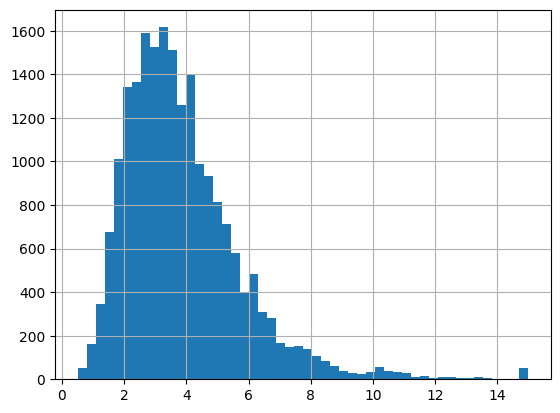

In [8]:
housing["median_income"].hist(bins=50)

La función `pd.cut` de Pandas nos permite crear una nueva columna segmentando en categorías. En este caso, vamos a crear 5 categorías, separando en bloques de 1.5 (salvo el ultimo que agrupará toda la cola gruesa a la derecha), y vamos a usar la función `value_counts` para ver cuántos valores hay en cada categoría.

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # Secuencia de límites de los contenedores
                               labels=[1, 2, 3, 4, 5])

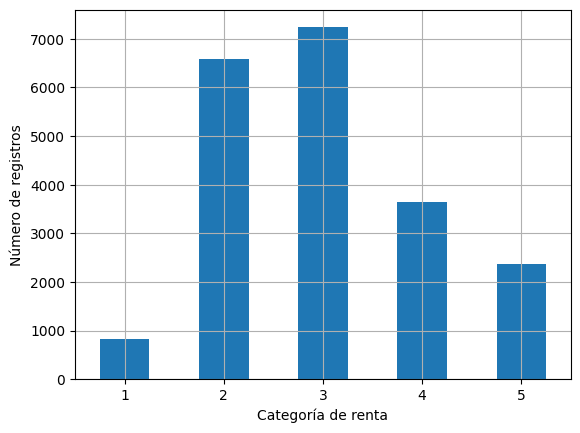

In [10]:
import matplotlib.pyplot as plt

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Categoría de renta")
plt.ylabel("Número de registros")
plt.show()

podemos volver a usar la función `train_test_split` de scikit-learn, pero esta vez con el parámetro `stratify` indicando la columna que queremos usar para estratificar el muestreo.

In [12]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"])

se observa que el conjunto de prueba generado usando muestreo estratificado una cantidad de muestras en cada estrato mucho más representativa de la población total, pese a ser aleatorio.

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Ahora podemos mostrar un dataframe completo con los errores de muestreo aleatorio y estratificado, y ver que el error de muestreo estratificado es mucho menor.

In [15]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data) # proporción de valores en cada income_cat

train_set, test_set = train_test_split(housing, test_size=0.2) # reejeecutando esta celda podemos ver la variación en el split aleatorio

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing), # proporción de valores en cada income_cat en el dataset original
    "Stratified %": income_cat_proportions(strat_test_set), # proporción en el conjunto de test estratificado
    "Random %": income_cat_proportions(test_set), # proporción en el conjunto de test generado aleatoriamente
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1) # error del estratificado con respecto al original
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1) # error del aleatorio con respecto al original
(compare_props * 100).round(2) # convertimos todos los valores a porcentaje con dos decimales

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,3.54,0.36,-11.19
2,31.88,31.88,31.86,-0.02,-0.09
3,35.06,35.05,34.98,-0.01,-0.22
4,17.63,17.64,18.75,0.03,6.35
5,11.44,11.43,10.88,-0.08,-4.95


Como ya no necesitaremos la variable `income_cat`, podemos eliminarla de los dos conjuntos generados.

In [16]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

strat_train_set.head().T

,19504,1406,12615,8359,12255
longitude,-121.02,-122.05,-121.51,-118.32,-117.02
latitude,37.65,37.95,38.5,33.97,33.76
housing_median_age,20.0,34.0,25.0,46.0,20.0
total_rooms,2973.0,1408.0,4719.0,1504.0,1317.0
total_bedrooms,620.0,277.0,745.0,270.0,203.0
population,1996.0,738.0,1857.0,814.0,453.0
households,570.0,269.0,739.0,306.0,158.0
median_income,3.0645,4.175,5.0371,4.3919,2.8393
median_house_value,106000.0,169400.0,180200.0,157100.0,120700.0
ocean_proximity,INLAND,NEAR BAY,INLAND,<1H OCEAN,INLAND
